# Training a simple BDT using scikit-learn
#### `Justin Tan, CoEPP - 02/02/2017`

Machine learning is a key part of multivariate analysis in particle physics. In this notebook we will train a simple BDT to tackle the binary classification problem: discriminating signal from a continuum background. This notebook makes use of Python's `scikit-learn`, and use a range of metrics to evaluate classifier performance. We assume features are given as ROOT format and cast them to `numpy` arrays using the excellent `root_numpy` package. All subsequent analysis is fully general.

`TMVA` in ROOT :seedling: has distinct advantages - such as simple macros and a useful GUI to aid visualization, but is relatively rigid and has a steep learning curve. In the Kaggle Higgs ML challenge, traditional BDTs trained using `TMVA` ranked lower than 300th in the final leaderboards. The winning entry was an ensemble of > 70 neural networks utilizing methods that would be either unavailable or a lot of work to implement in TMVA (eg. dropout, XGBoost, stratified CV)...

`scikit-learn` is much more flexible and offers a range of modern tools unavailable in the `TMVA` library, which may help to push your analysis that one step further.

### `TO-DO:`
1. Feature Selection
  - Intelligent feature ranking
  - Automated feature selection
  - Explore feature engineering
2. Model improvements
  - Hyperparameter grid search (minor)
  - Regularization. Lots.
  - Train sub-BDTs throughout decay chain (Hierarchial?) 
  - Port to TensorFlow (Neural nets)
3. Performance evaluation
  - Develop better metrics

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from root_numpy import root2array, rec2array, array2root
import ROOT
import sys, glob, os, time

from sklearn import datasets
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.externals import joblib

mpl.rcParams.update({'font.size': 12})

/home/justan/anaconda3/envs/py34/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data visualization 

Its always helpful to visualize data before beginning an extended training run. Highly correlated variables may render the tree structure unstable to statistical fluctuations and generally does not help with separation power.

In [3]:
def plot_correlations(data,tree_name):
    # Plot correlation matrix elements between features as a heatmap
    corrmat = data.corr()
    f, ax = plt.subplots(figsize=(14,11))
    sns.heatmap(corrmat, square=True, cmap='RdBu')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    f.tight_layout()
    plt.title("Correlation coefficients - " + tree_name)
    f.savefig('graphs/' + tree_name + 'correlations.png')
    plt.show()
    plt.gcf().clear()

In [440]:
def truncate_tails(hist, nsigma = 4.5):
    hist = hist[hist > np.mean(hist)-nsigma*np.std(hist)]
    hist = hist[hist < np.mean(hist)+nsigma*np.std(hist)]
    return hist

In [443]:
def compare_histograms(data_sig, data_bkg, tree_name, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    if (not columns):
        columns_sig = [data_sig[variable].values for variable in columns]
        columns_bkg = [data_bkg[variable].values for variable in columns]
        if (columns_sig != columns_bkg):
            raise ValueError('Both input dataframes must have identically named columns!\n')
            return
    for variable in columns:
        data_array_sig = data_sig[variable].values
        d_bkg = data_bkg[variable].values
        
        # Truncate problematic tails
        data_array_bkg = truncate_tails(d_bkg)
        
        plt.hist(data_array_sig, bins=nbins, alpha=0.5, color = sea_green, label = 'Signal', 
                 weights = np.ones(data_array_sig.shape[0])*1/data_array_sig.shape[0])
        plt.hist(data_array_bkg, bins=nbins, alpha=0.3, color = steel_blue, label = 'Background', 
                 weights = np.ones(data_array_bkg.shape[0])*1/data_array_bkg.shape[0])
        plt.title(variable + ' - v0.1')
        plt.xlabel(variable)
        plt.ylabel('Fraction of events per bin')
        plt.legend(loc = "upper right")
        plt.savefig('graphs/' + tree_name + variable + '.png')
        plt.show()
        plt.gcf().clear()

## Performance Evaluation

Ranks features by the expected fraction of events they directly classify. Yields crude estimation of feature importance, but subject to statistical fluctuations.

In [393]:
def plot_feature_rank(bdt, tree_name, branch_names):
    # Rank features by the expected fraction of input events they contribute to the classification of
    # update with a smarter version
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    
    importances = bdt.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in bdt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    ranked_labels = [branch_names[rank] for rank in indices]

    for f in range(features.shape[1]):
        print("%d. feature %d - %s `(%f)" % (f + 1, indices[f], branch_names[indices[f]], importances[indices[f]]))
    
    # Plot feature importances
    plt.figure(figsize=(14,11))
    plt.title("Feature ranking")
    plt.bar(range(features.shape[1]), importances[indices], color=steel_blue, align='center')
    plt.xticks(range(features.shape[1]), indices)
    plt.xlim([-1,features.shape[1]])
    plt.xticks(np.arange(len(ranked_labels)), ranked_labels, rotation = 90)
    plt.savefig("graphs/" + tree_name + "simplefeaturerank.png")
    plt.show()
    plt.gcf().clear()

In [5]:
def plot_ROC_curve(clf, X_val, y_val, tree_name, meta_info):
    # Plots receiver operating characteristic for given classifier
    from sklearn.metrics import roc_curve, auc
    # Compute BDT decision function on validation data
    decisions = clf.decision_function(X_val)
    # Compute ROC curve, integrate
    fpr, tpr, thresholds = roc_curve(y_val, decisions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.axes([.1,.1,.8,.7])                           
    plt.figtext(.5,.9, 'Receiver operating characteristic (' + tree_name +')', fontsize=15, ha='center')
    plt.figtext(.5,.85, meta_info,fontsize=10,ha='center')
    plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2.0, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig("graphs/" + tree_name + "ROCcurve.png")
    plt.show()
    plt.gcf().clear()

In [7]:
def plot_BDT_output_balanced(clf, X_train, X_test, y_train, y_test, tree_name, meta_info, numbins=25):
    # Plot classifier decision function for each class. superimpose classifier output for
    # training sample and the independent validation sample to check for overfitting, use
    # only if classes are relatively balanced
    decisions = []
    # Run classifier on train, test data. Unravel to flattened array
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1,d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    hist_range = (low,high)

    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, 'BDT Output', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')

    # Histogram training data
    plt.hist(decisions[0], color = 'g', alpha = 0.5, range = hist_range, bins = numbins, histtype='stepfilled', label='Signal (train)')
    plt.hist(decisions[1], color = 'b', alpha = 0.5, range = hist_range, bins = numbins, histtype='stepfilled', label='Background (train)')

    # Overlay training histogram with test data histogram, plotted as error-bar histograms
    hist, bins = np.histogram(decisions[2], bins=numbins, range=hist_range)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, yerr = err, fmt='o',c='g', label = 'Signal (test)')

    hist, bins = np.histogram(decisions[3], bins=numbins, range=hist_range)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label = 'Background (test)')
    plt.xlabel("Classifier Output")
    plt.ylabel("Entries/bin")
    plt.legend(loc='best')
    plt.savefig("graphs/" + tree_name + "BDToutput.png")
    plt.show()
    plt.gcf().clear()

## Model persistence + Preprocessing

In [8]:
# Specify branch names you don't want to feed into the classifier
def pruned(branch_names):
    unwanted = ['B0__momDevChi2','X','Y','Z','VtxProd','Signal', 'isNot', 'nCands', 'iCand', 'B0__isNotContinuumEvent', 'B0__InvM', 'B0__SigM']
    pruned_branch_list = []
    for feature in branch_names:
        flag = False
        for bad_string in unwanted:
            if (bad_string in feature):
                flag = True
        if (not flag):
            pruned_branch_list += [feature]
    return pruned_branch_list

In [9]:
def output_to_ROOT(clf, X):
    
    # Outputs BDT predictions on entire dataset to a ROOT file for later analysis

    y_predicted = bdt.decision_function(X)
    y_predicted.dtype = [('y', np.float64)]

    array2root(y_predicted, "clf_output.root", "BDToutput")

In [10]:
def save_classifier(clf, filename):
    # Save classifier for later reuse, reload with:
    # >> clf = joblib.load(filepath)

    from tempfile import mkdtemp
    import os
    savedir = mkdtemp()
    filepath = os.path.join(savedir, filename)
    joblib.dump(clf, filepath)
    print("Saved at:" + filepath)
    return filepath

## The main body

We load the input data from a pair of ROOT files generated by a BASF2 steering file for the decay chain, available on the Github project page. Currently training is done using various $B -> X_{s+d} \gamma$ modes, using analysis-specific signal side selection.

$$ 
\begin{align}
B^0 &\rightarrow (K^{*0} \rightarrow K^+ \pi^-) \; \gamma \\
B^0 &\rightarrow (K^{*0} \rightarrow K_S^0 \pi^0) \; \gamma \\
B^+ &\rightarrow (K^{*+} \rightarrow K_S^0 \pi^+) \; \gamma \\
B^+ &\rightarrow (K^{*0} \rightarrow K^+ \pi^0) \; \gamma \\
B^0 &\rightarrow (\rho^0 \rightarrow \pi^+ \pi^-) \; \gamma
\end{align}
$$

The classifier was trained on $2.4$ million signal events and $X$ million continuum $q\bar{q}$ events. The preselection discarded nearly all continuum events so it is crucial to include enough Monte Carlo events to obtain a reasonable statistic for training. Training using this dataset took $X$ hours at KEKCC.

### ROOT to NumPy conversion

We convert the event data stored in the ROOT signal and background files to numpy arrays using the `root_numpy` package. We can control the features we want to train on by extracting the branch names directly from the ROOT TTree and pruning the unwanted branches.

In [354]:
# Specify input ROOT files here and the decay mode
sig_input = "ewp/kstar0/B02Kstargammasignal.root"
bkg_input = "ewp/kstar0/B02Kstargammaqqbar.root"
mode = "B02Kstar_gamma"

In [558]:
# Read ROOT files into numpy arrays
sigFile = ROOT.TFile(sig_input)
bkgFile = ROOT.TFile(bkg_input)
sig_tree_names = [key.GetName() for key in sigFile.GetListOfKeys()]
bkg_tree_names = [key.GetName() for key in bkgFile.GetListOfKeys()]

sigB0Tree = sigFile.Get('B0')
bkgB0Tree = bkgFile.Get('B0')

# Prune unwanted branches from the TTree, try CS only
original_names = [b.GetName() for b in sigB0Tree.GetListOfBranches()]
sig_branch_names = pruned([b.GetName() for b in sigB0Tree.GetListOfBranches()])[:32]
bkg_branch_names = pruned([b.GetName() for b in bkgB0Tree.GetListOfBranches()])[:32]

if (sig_branch_names != bkg_branch_names):
    print("Error! Feature lists should be consistent between signal and background.")
    
branch_names = sig_branch_names
#branch_names = [b.replace("__", "_") for b in branch_names]

signal = root2array(sig_input, 'B0', branch_names)
signal = rec2array(signal)

bkg = root2array(bkg_input, 'B0', branch_names)
bkg = rec2array(bkg)

In [559]:
branch_names

['B0_ThrustB',
 'B0_ThrustO',
 'B0_CosTBTO',
 'B0_CosTBz',
 'B0_R2',
 'B0_cc1',
 'B0_cc2',
 'B0_cc3',
 'B0_cc4',
 'B0_cc5',
 'B0_cc6',
 'B0_cc7',
 'B0_cc8',
 'B0_cc9',
 'B0_mm2',
 'B0_et',
 'B0_hso00',
 'B0_hso01',
 'B0_hso02',
 'B0_hso03',
 'B0_hso04',
 'B0_hso10',
 'B0_hso12',
 'B0_hso14',
 'B0_hso20',
 'B0_hso22',
 'B0_hso24',
 'B0_hoo0',
 'B0_hoo1',
 'B0_hoo2',
 'B0_hoo3',
 'B0_hoo4']

In [43]:
# For testing
sig_input = "Higgs/1920200"
bkg_input = "Higgs/1920208"
sigFile = ROOT.TFile(sig_input)
bkgFile = ROOT.TFile(bkg_input)
sig_tree_names = [key.GetName() for key in sigFile.GetListOfKeys()]
bkg_tree_names = [key.GetName() for key in bkgFile.GetListOfKeys()]

sigB0Tree = sigFile.Get('tree')
bkgB0Tree = bkgFile.Get('tree')

# Prune unwanted branches from the TTree
sig_branch_names = [b.GetName() for b in sigB0Tree.GetListOfBranches()]
bkg_branch_names = [b.GetName() for b in bkgB0Tree.GetListOfBranches()]

if (sig_branch_names != bkg_branch_names):
    print("Error! Feature lists should be consistent between signal and background.")
    
branch_names = sig_branch_names
branch_names.remove('y')
#branch_names = [b.replace("__", "_") for b in branch_names]

signal = root2array(sig_input, 'tree', branch_names)
signal = rec2array(signal)

bkg = root2array(bkg_input, 'tree', branch_names)
bkg = rec2array(bkg)

In [563]:
signal.shape

(559727, 32)

In [564]:
bkg.shape

(37949, 32)

In [565]:
signal = signal[np.random.choice(signal.shape[0],25000)]
signal.shape

(25000, 32)

In [566]:
bkg = bkg[np.random.choice(bkg.shape[0],25000)]
bkg.shape

(25000, 32)

Next we extract the features from the data, and generate truth labels. The complete dataset is stored as a Pandas dataframe for easy access. The dataset is paritioned into training and testing sets twice to ensure no overfitting occurs when we exploit the validation set for hyperparameter tuning.

In [567]:
# scikit-learn data organized into 2D array of shape (n_samples, n_features)
features = np.concatenate((signal,bkg))
labels = np.concatenate((np.ones(signal.shape[0]), np.zeros(bkg.shape[0])))

# Store data in pandas dataframe - 2D size mutable tabular structure with labelled axes
# permits quick operations on features
df = pd.DataFrame(np.hstack((features, labels.reshape(labels.shape[0],-1))), columns = branch_names + ['labels'])

# Access rows in dataframe satisfying this condition
bkg_bool = df['labels'] < 0.5
sig_bool = df['labels'] > 0.5

# We parititon the data into separate training, testing sets twice
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15, random_state=432)
X_use, X_val, y_use, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 213)

## Feature Visualization

### Comparing feature distributions

The distribution of features with the strongest discriminating power between signal and background for this particular model is plotted below.

1. feature 32 - B0__q2Bh `(0.058507)
2. feature 5 - B0_cc1 `(0.041430)
3. feature 36 - B0__chiProb `(0.038360)
4. feature 38 - B0__daughterAngle__bo0__cm1__bc `(0.037655)
5. feature 23 - B0_hso14 `(0.033928)

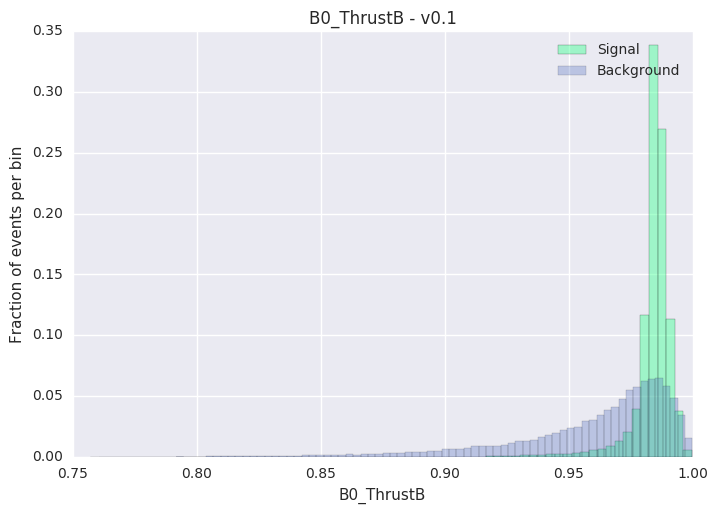

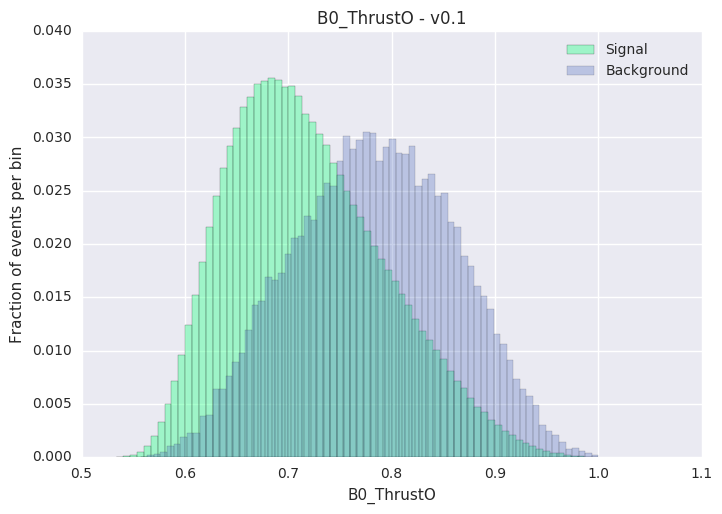

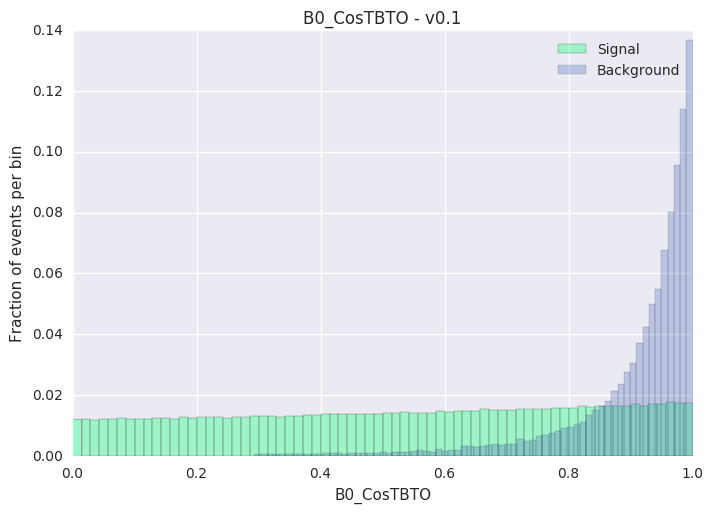

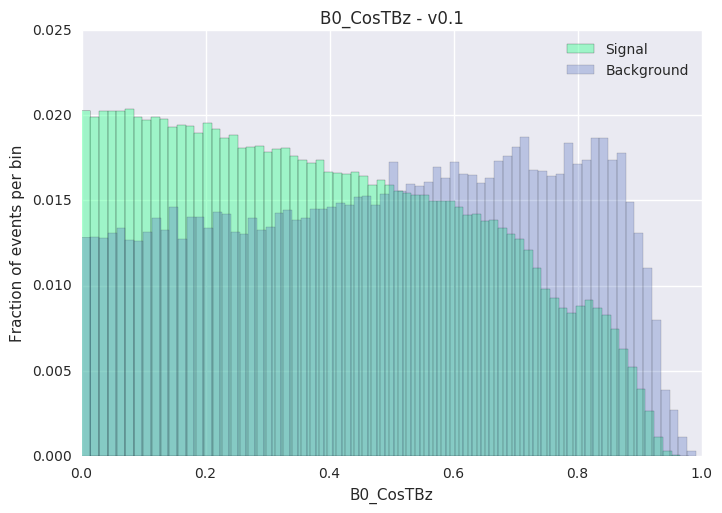

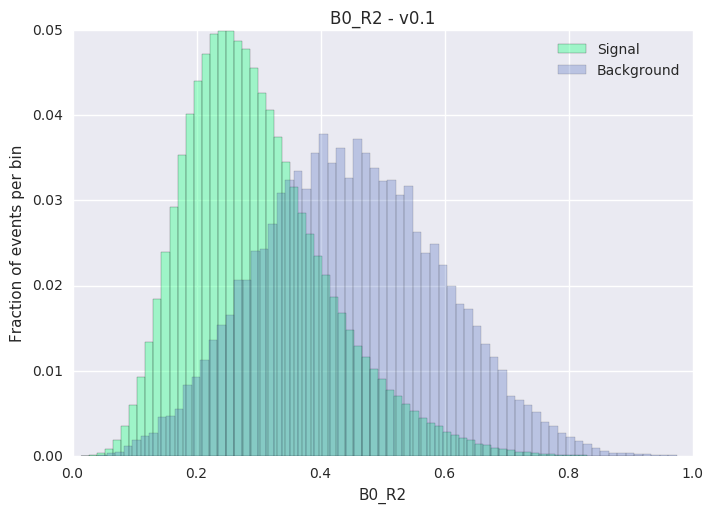

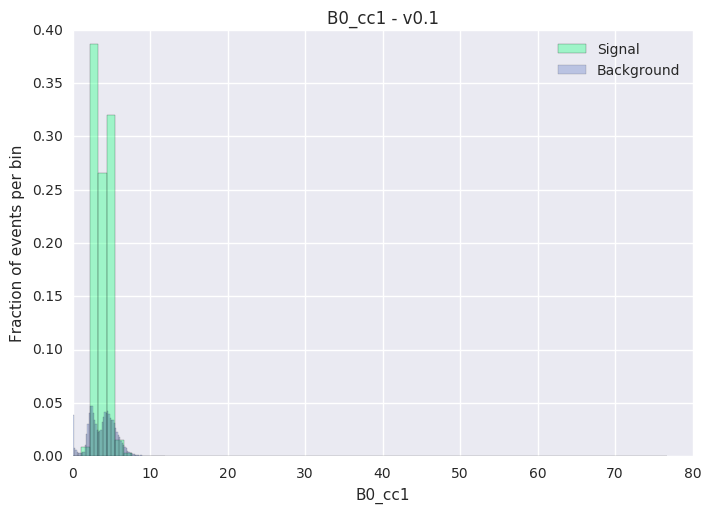

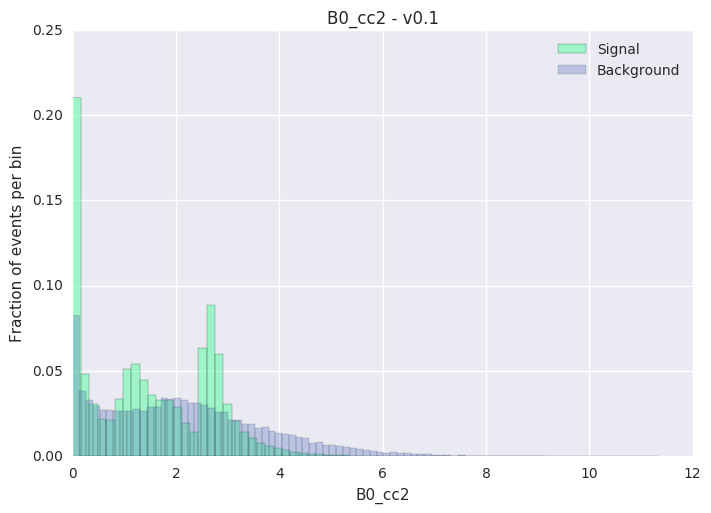

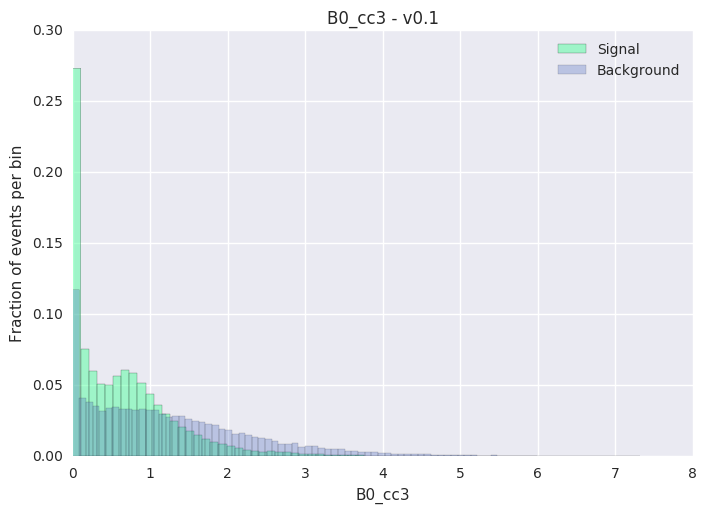

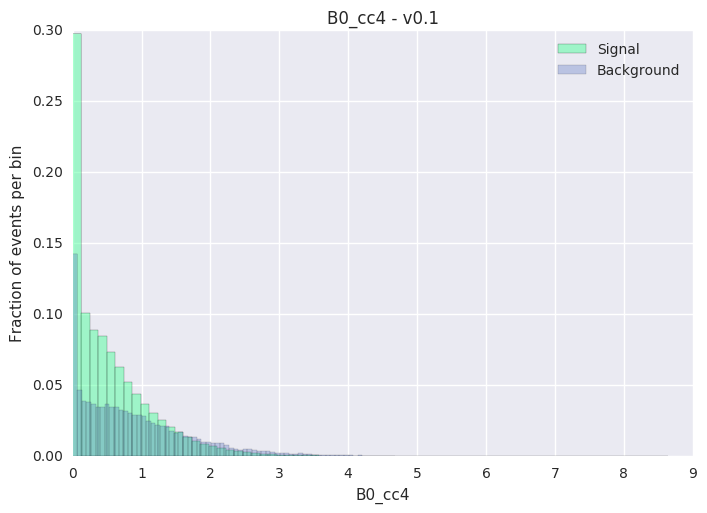

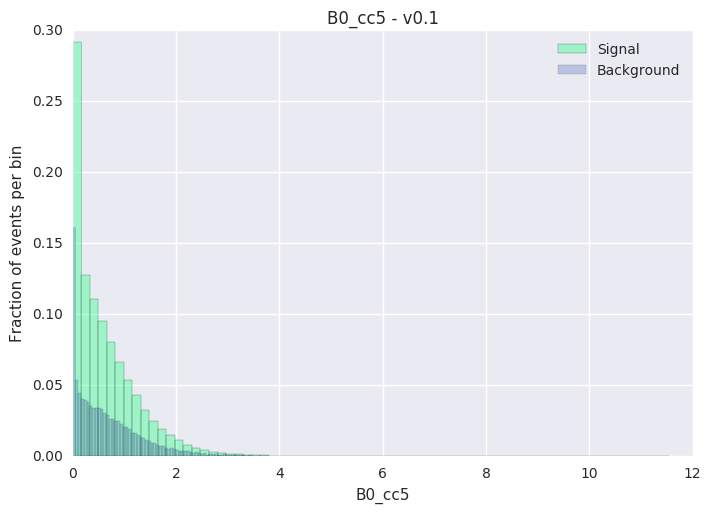

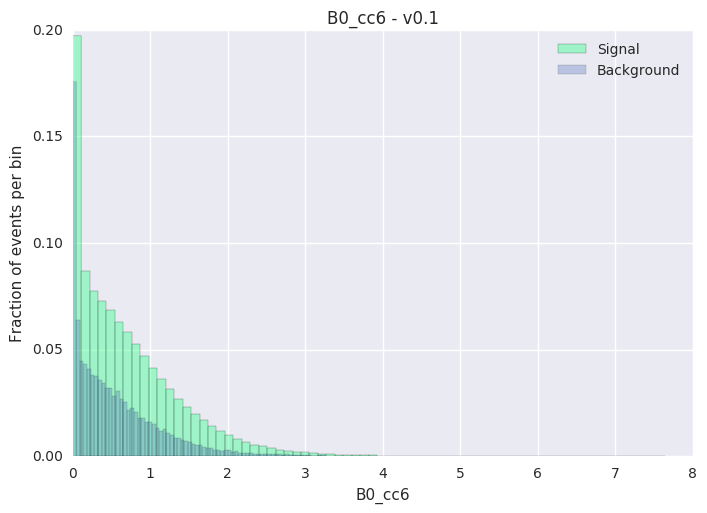

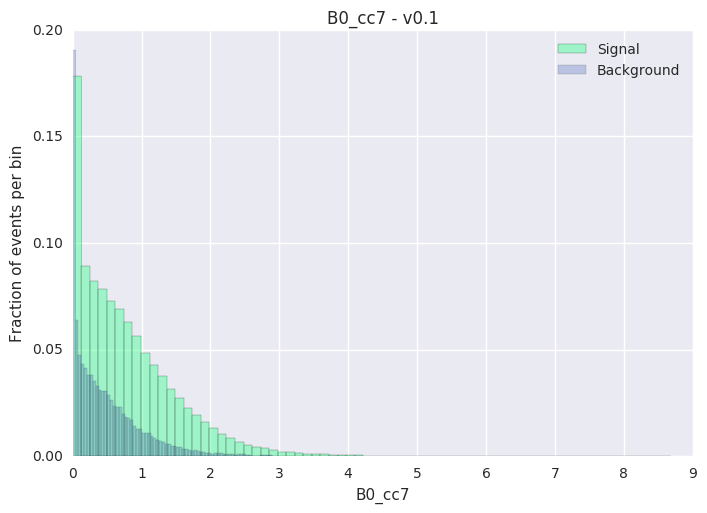

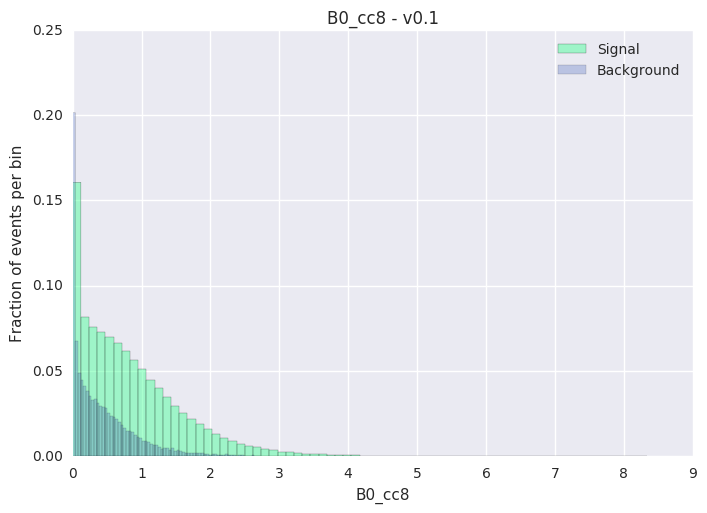

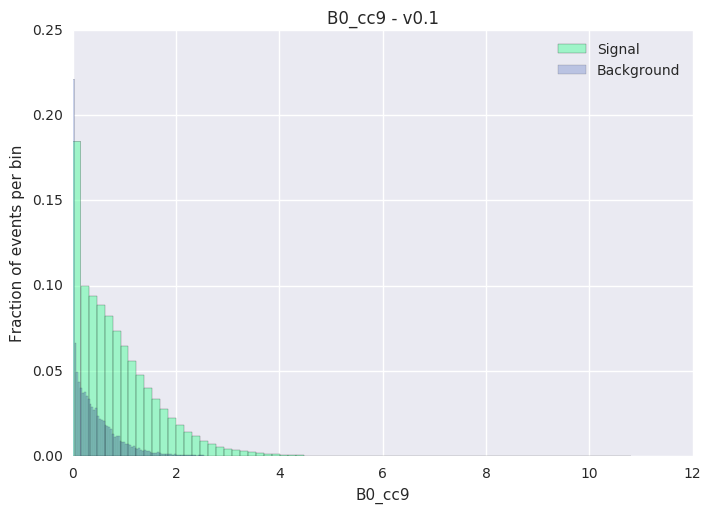

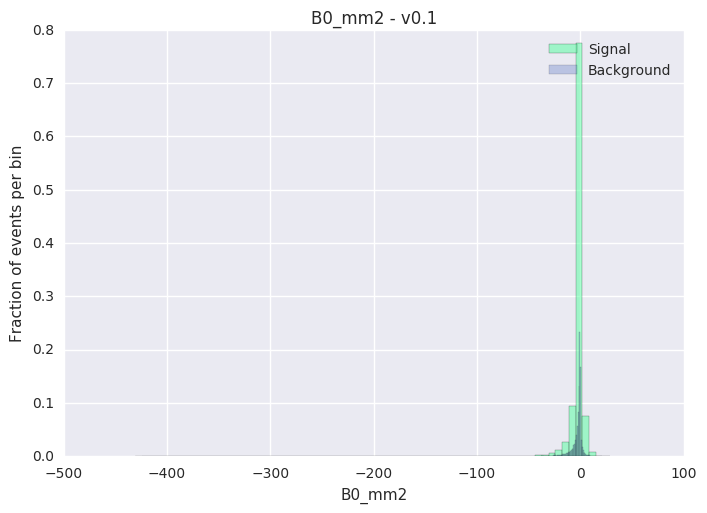

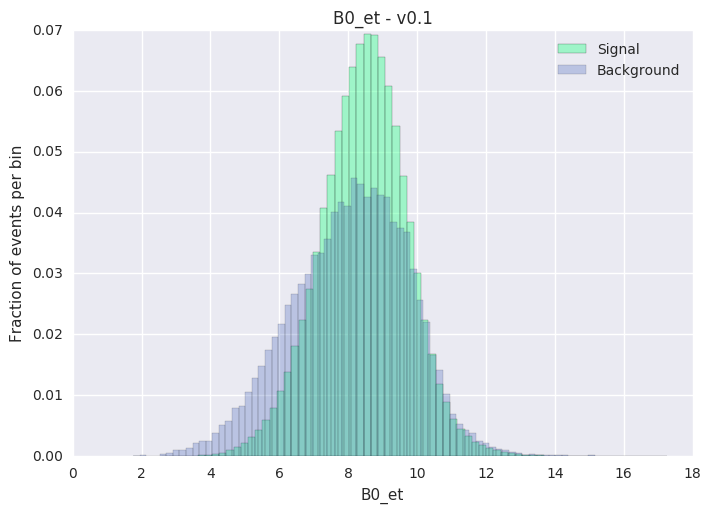

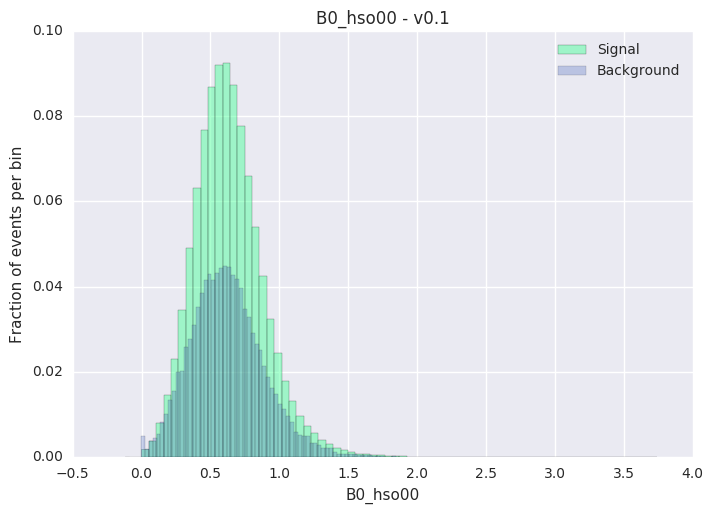

/home/justan/anaconda3/envs/py34/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/justan/anaconda3/envs/py34/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/justan/anaconda3/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:5882: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  '(shape is %d x %d)' % inp.shape[::-1])


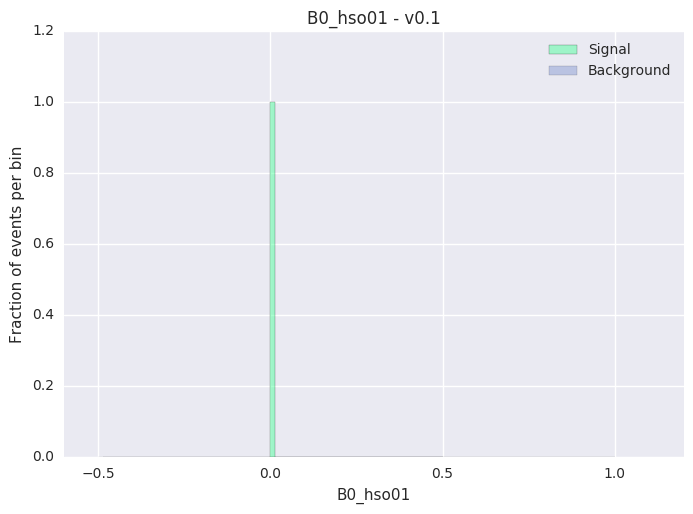

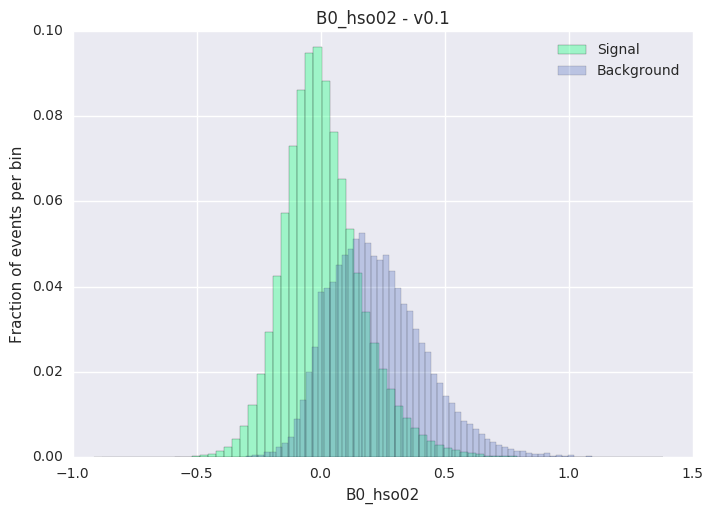

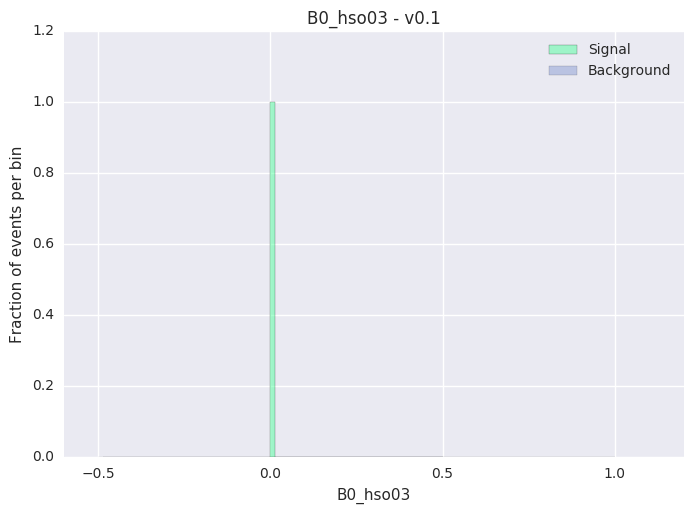

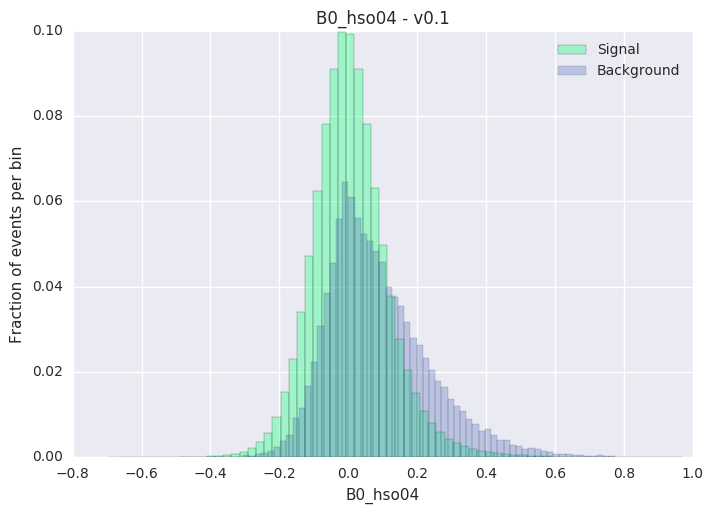

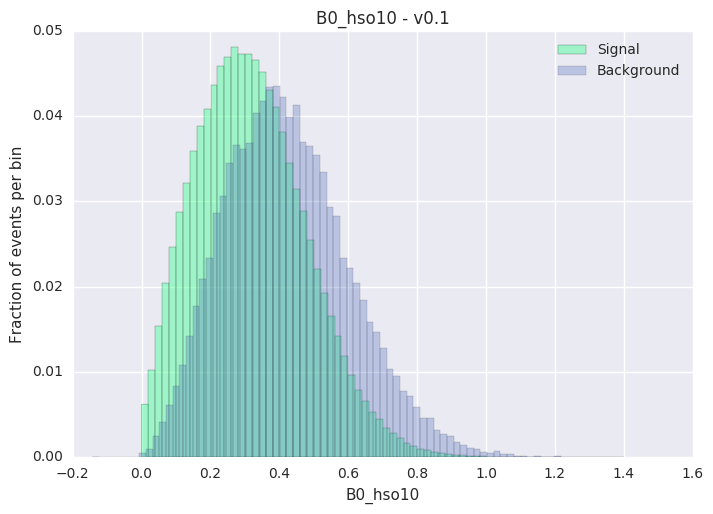

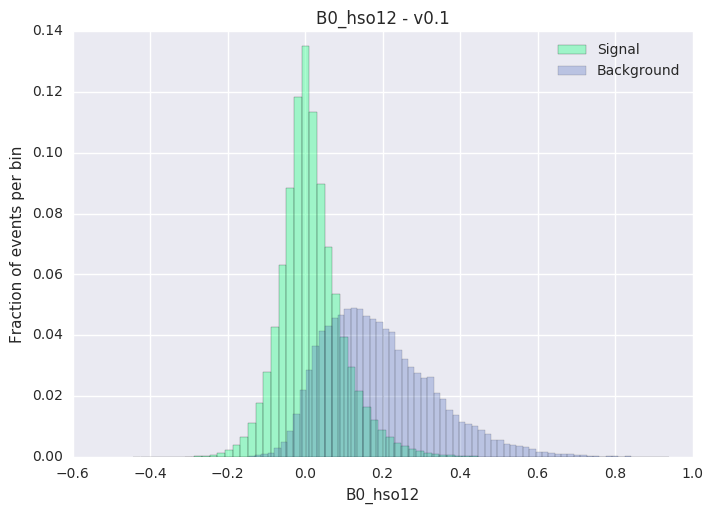

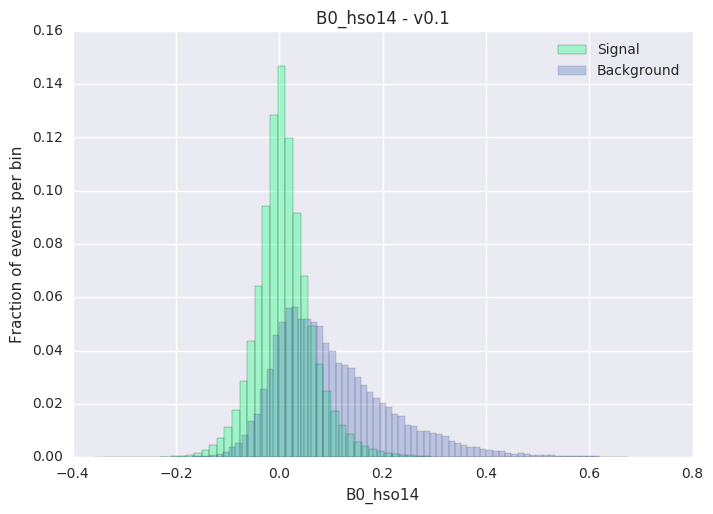

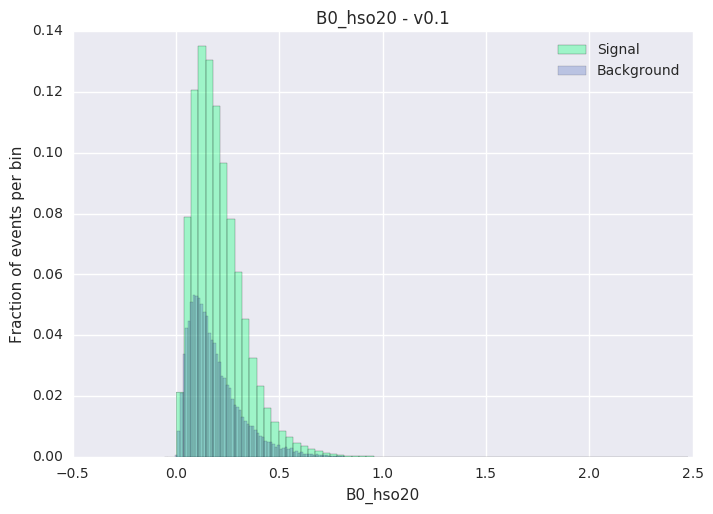

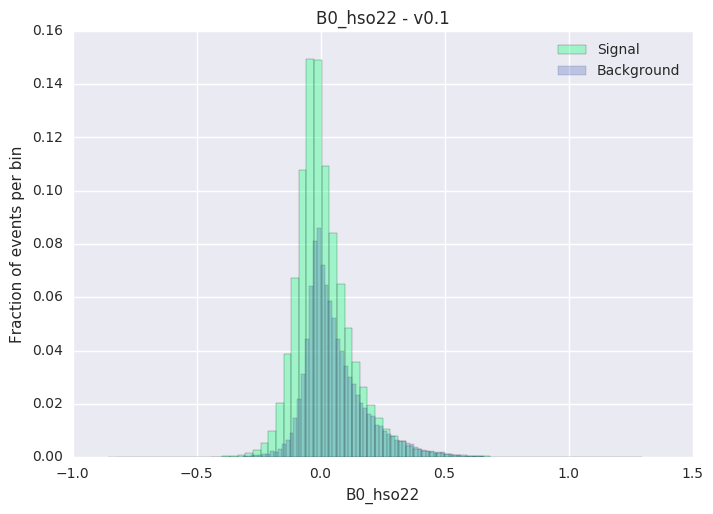

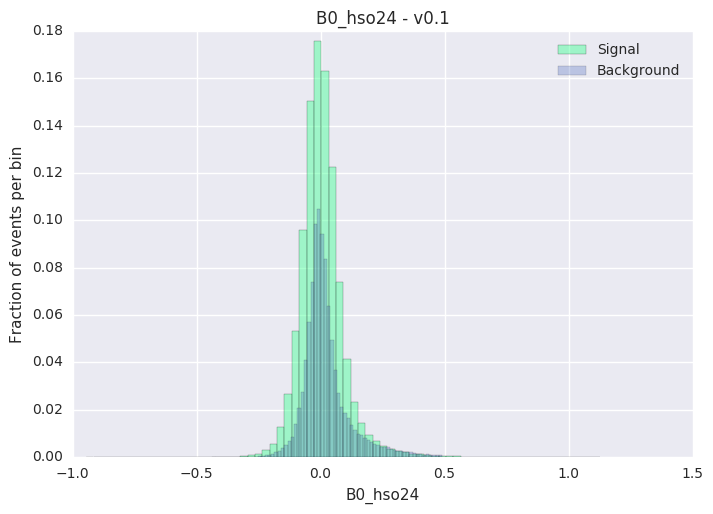

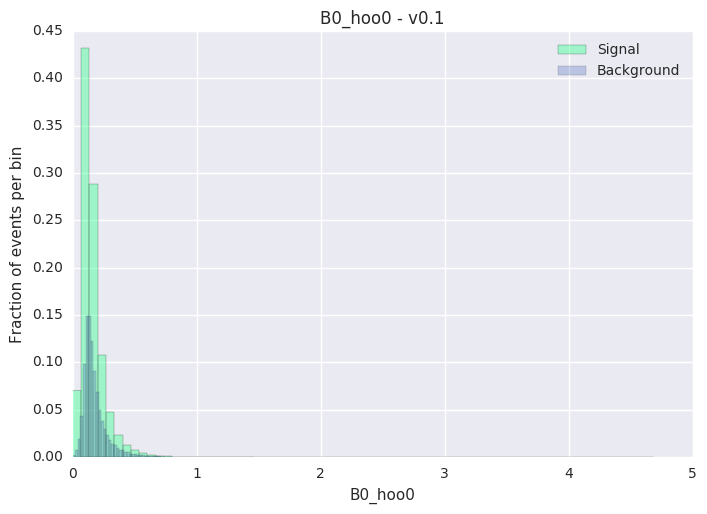

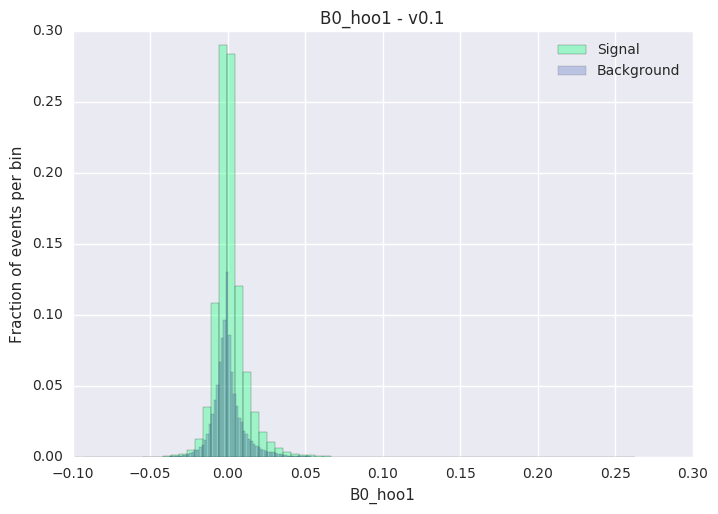

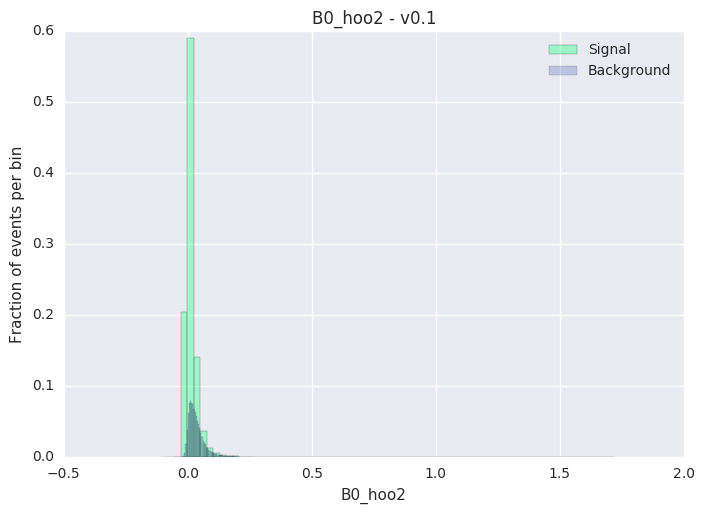

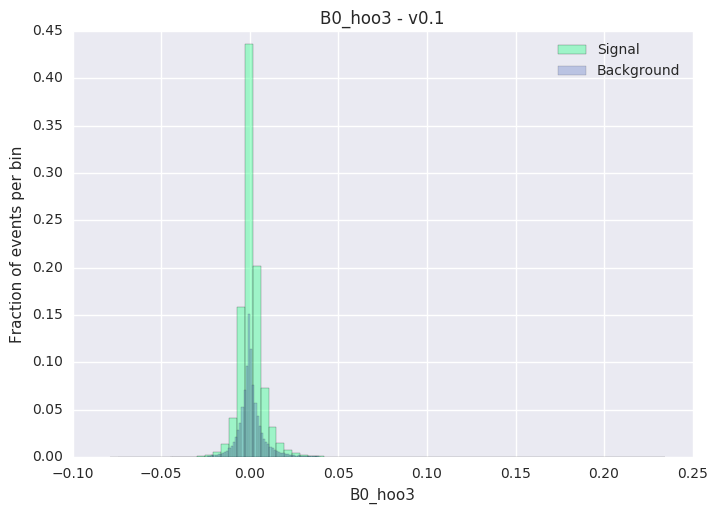

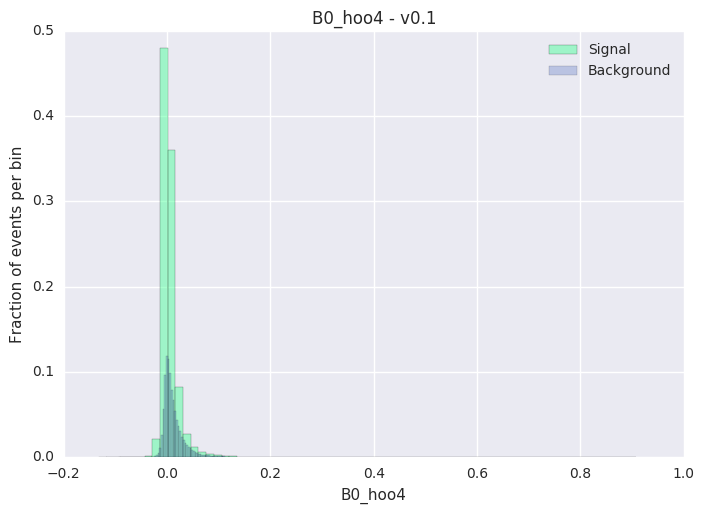

In [561]:
compare_histograms(df[sig_bool], df[bkg_bool], mode, 70, branch_names)

### Plot feature correlations

Plot feature correlations for both signal and background, as mentioned previously, the BDT structure is unstable against statistical fluctuations if highly correlated features are used during training.

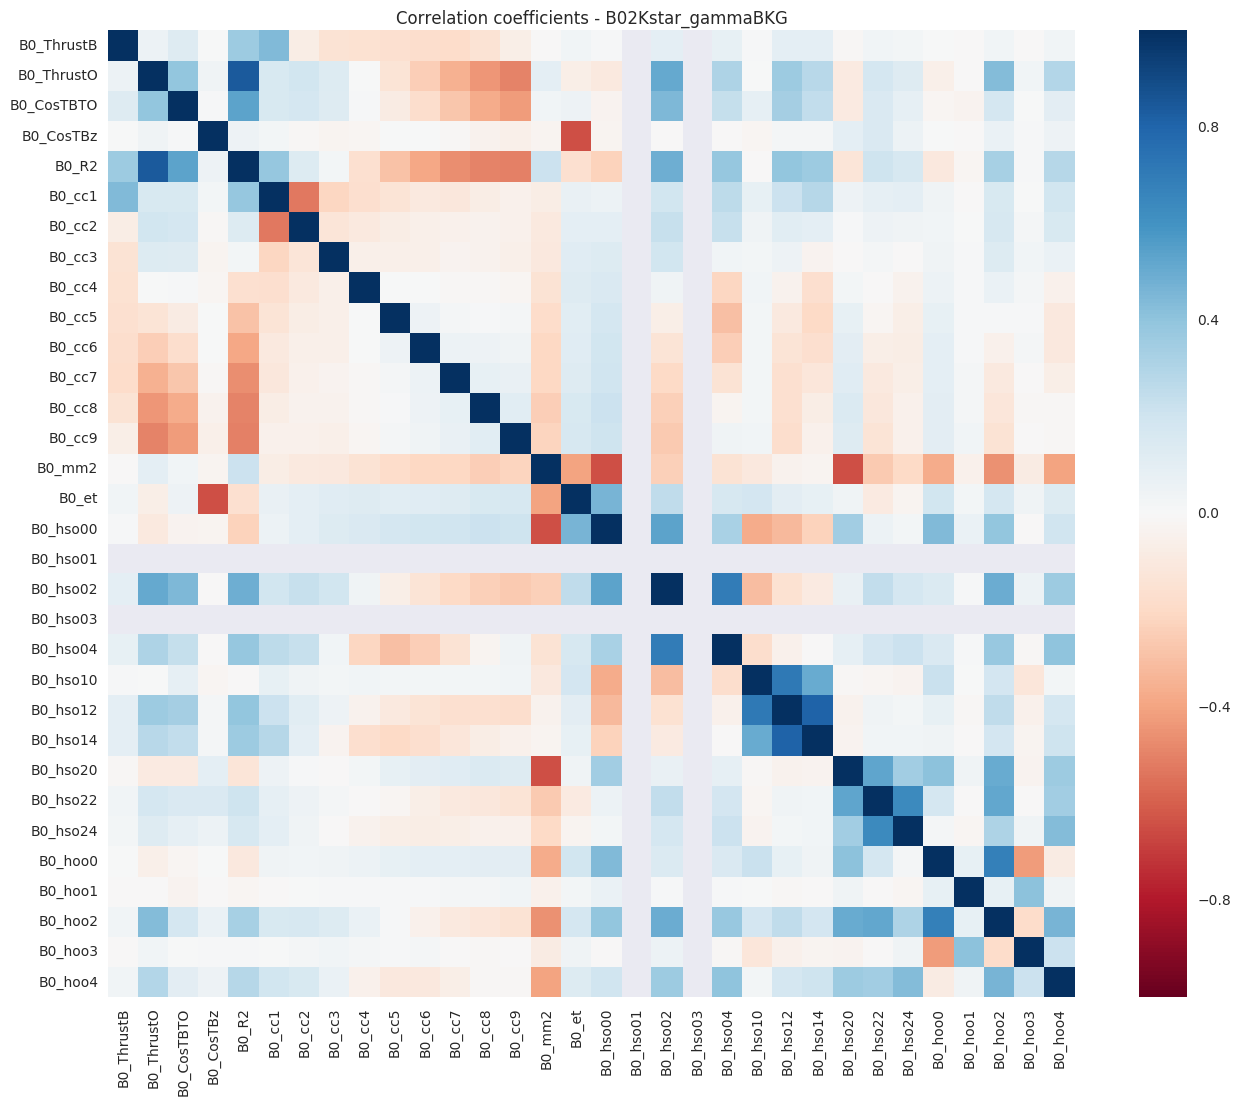

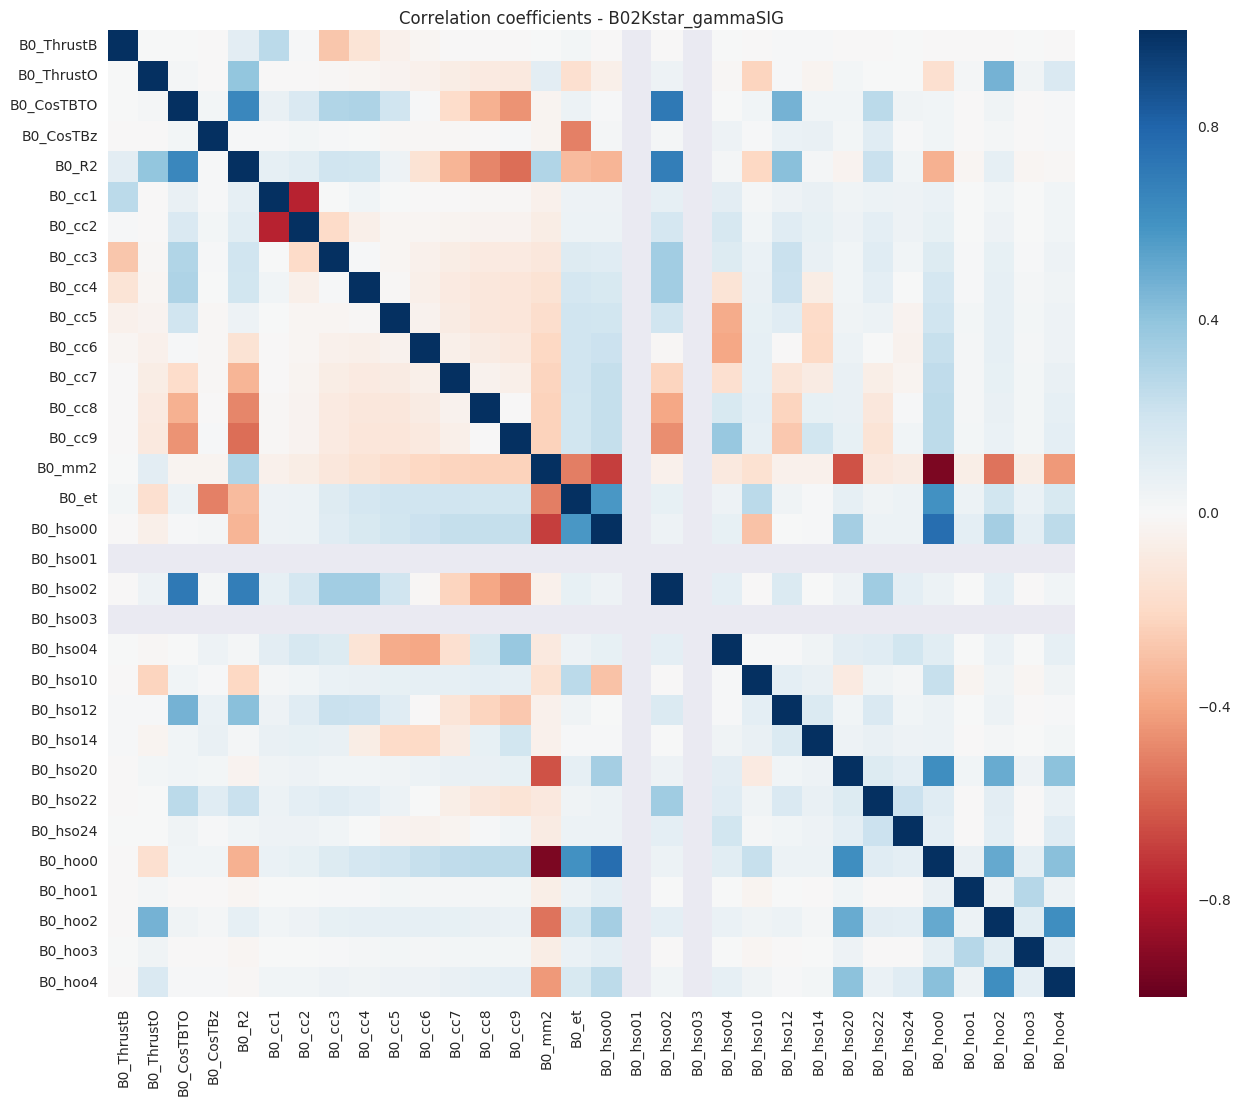

In [562]:
plot_correlations(df[bkg_bool].drop('labels',1), mode + 'BKG')
plot_correlations(df[sig_bool].drop('labels',1), mode + 'SIG')

## Training the Decision Tree

#### AdaBoost

With `scikit-learn`, training a classifier is embarassingly easy. As always, there is a convenience-power tradeoff. The hyperparameters of your model can be optimized via a grid search. Here we use some values commonly found in the Belle/Belle II literature, and the **Ada**ptive **Boost**ing (AdaBoost) algorithm. Other classifiers are very easily trained, see the `scikit-learn` [documentation](http://scikit-learn.org/stable/modules/ensemble.html#adaboost) for more information on available classifiers. 

A decision tree recursively partitions feature space into regions classifiable as 'signal' or 'background' using a suitable metric. We choose our impurity measure as the Gini Index. Intuitively, a decision tree filters impure mixtures of classes to relatively pure samples at the terminal nodes. The impurity metric should be strictly concave to reward purer nodes, symmetric between classes and minimal for pure nodes. 

At a bifurcation in the decision tree the variable and cut value that maximizes the decrease in impurity between the parent and daughter nodes, weighted by their relative fraction of events is chosen. The multiclass Gini index has a straightforward interpretation as the probability of misclassification.

$$ \sum_{i, j \; \in \; \mathrm{classes}}^{i \neq j} p_i p_j $$

$$ \mathrm{Binary:} \; G = p_s(1-p_s) + p_b(1-p_b) = 1 - (1-p)^2 - p^2 = 2p(1-p) $$

If we define the signal and background purity as below, we get a simple expression for the criterion.

$$ p_s = \frac{s}{s+b}, \: p_b = \frac{b}{s+b} \implies G = \frac{2sb}{(s+b)^2}
$$

**Caution:** run the following cell only if loading a pretrained classifier

In [ ]:
bdt = joblib.load('/scratch/tmpnxkwm43n/babysfirstBDT.pkl')
clf_meta = "AdaBoost - criterion=Gini, max_depth=5, n_est=800, beta=0.5"

Here we start our model out with $800$ estimators, a maximum tree depth of $5$, and $\beta =0.5$

In [571]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Set model hyperparameters
CRITERION = "gini"
MAX_DEPTH = 4
MIN_SAMPLES_LEAF = 0.04 
MIN_IMPURITY_SPLIT = 1e-7
BETA = 0.5
BASE_ESTIMATORS = 1500
clf_meta = "AdaBoost BDT - criterion = "+str(CRITERION)+", max_depth = "+str(MAX_DEPTH)+", base_est="+str(BASE_ESTIMATORS)+", beta="+str(BETA)

# Begin classifier training ________________________________________________________________________________________________________
t0 = time.time()
print("Training starts now")
# Select base classifier
dt = DecisionTreeClassifier(criterion = CRITERION, max_depth = MAX_DEPTH, min_samples_leaf = MIN_SAMPLES_LEAF, max_features = 'auto') # class_weight="balanced") 
# Adaptive boosting algorithm
bdt = AdaBoostClassifier(dt, n_estimators = BASE_ESTIMATORS, learning_rate = BETA)
# Train the classifier on selected data
%time bdt.fit(X_use, y_use)

print("Training complete. Time elapsed: %0.3fs" % (time.time() - t0))
clf_meta += ', training: %ds' % (time.time() - t0)
# Model persistance
save_path = save_classifier(bdt, filename = 'babysfirstBDT.pkl')
# To resume, bdt = joblib.load(save_path)

Training starts now
CPU times: user 5min 2s, sys: 0 ns, total: 5min 2s
Wall time: 5min 7s
Training complete. Time elapsed: 307.462s
Saved at:/scratch/tmpfw2ymhcf/babysfirstBDT.pkl


#### Gradient Boosting

We can also train a gradient boosting classifier for comparison.

In [366]:
from sklearn.ensemble import GradientBoostingClassifier

# Set model hyperparameters
MAX_DEPTH = 3
MAX_FEATURES = 'sqrt'
MIN_SAMPLES_LEAF = 0.04 
MIN_IMPURITY_SPLIT = 1e-7
BETA = 0.1
BASE_ESTIMATORS = 1800
SUBSAMPLE = 0.95

gbt = GradientBoostingClassifier(n_estimators = BASE_ESTIMATORS,
                                 max_depth = MAX_DEPTH,
                                 subsample = SUBSAMPLE,
                                 max_features = MAX_FEATURES,
                                 learning_rate = BETA)

# Begin classifier training ________________________________________________________________________________________________________
t0 = time.time()
print("Training starts now")
%time gbt.fit(X_use, y_use)

print("Training complete. Time elapsed: %0.3fs" % (time.time() - t0))

# Model persistance
save_path = save_classifier(bdt, filename = 'babysfirstBDT.pkl')
# To resume, bdt = joblib.load(save_path)

Training starts now
CPU times: user 4min 35s, sys: 85 ms, total: 4min 35s
Wall time: 4min 35s
Training complete. Time elapsed: 275.906s
Saved at:/scratch/tmpov96fdm5/babysfirstBDT.pkl


## Evaluating Feature Performance

Now we will plot some metrics to visualize the classifier performance.

### Classification Report

In [572]:
y_pred = bdt.predict(X_test)
onehots = np.equal(y_pred,y_test)
acc = np.count_nonzero(onehots)/np.shape(y_pred)[0]
print(acc)

0.9484


In [573]:
y_pred = bdt.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["background", "signal"]))

             precision    recall  f1-score   support

 background       0.94      0.95      0.95      3126
     signal       0.95      0.95      0.95      3249

avg / total       0.95      0.95      0.95      6375



In [367]:
y_pred = gbt.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["background", "signal"]))

             precision    recall  f1-score   support

 background       0.99      0.99      0.99      4840
     signal       0.99      0.99      0.99      7011

avg / total       0.99      0.99      0.99     11851



### Receiver Operating Characteristic

The true positive rate (recall) is plotted against the false positive rate (probability of false alarm). Used to evaluate classifier performance as we vary its discrimination threshold. The BDT output is a continuous random variable $X$. Given a threshold parameter $T$, the instance is classified as signal is $X>T$ and background otherwise. The random variable $X$ should follow a probability density $f_{sig}(x)$ if is true signal, and $f_{bkg}(x)$ otherwise. The respective rates are therefore given as cumulative density functions:

$$ \mathbf{TPR}(T) = \int_T^{\infty} dx \; f_{sig}(x), \; \; \mathbf{FPR}(T) = \int_T^{\infty} dx \; f_{bkg}(x), $$ 

The ROC curve plots $\mathbf{TPR}(T)$ versus $\mathbf{FPR}(T)$ with the discrimination threshold as the varying parameter. The optimal point in ROC - space is $(0,1)$ in the upper left corner, which is the error-free point. The gradient and area of the ROC curve are also useful metrics. The latter will be used as a testing metric, and is given by:

$$ \mathrm{AUC} = \theta = \int_{-\infty}^{\infty} dT \; \mathbf{TPR}(T) \; \frac{d\; \mathbf{FPR}}{dT}(T) $$

Area under ROC curve: 0.988


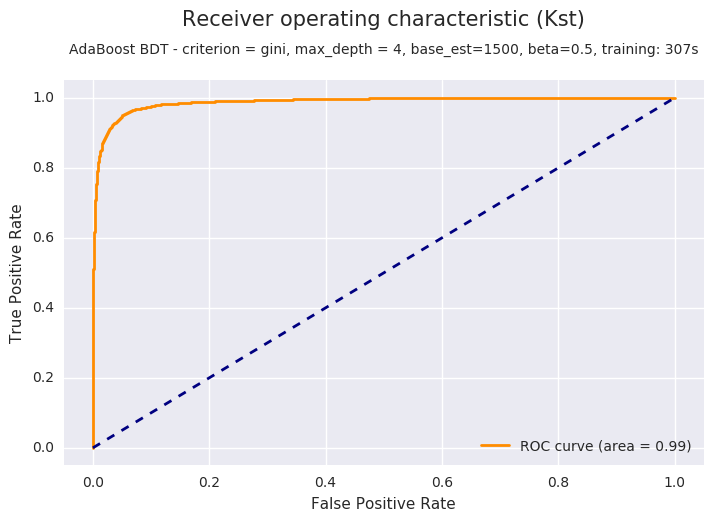

In [574]:
print("Area under ROC curve: %.3f" %(roc_auc_score(y_val, bdt.decision_function(X_val), average='weighted')))

plot_ROC_curve(bdt, X_val, y_val, sig_tree_names[0], clf_meta)

# recall = TP / (TP + FN)
# precision = TP / (TP + FP)

### Feature Ranking

Here the 'importance' of a feature is defined as the normalized reduction in the Gini criterion (the *Gini Importance*). Each bifurcation in the tree a on variable $X_i$ decreases the Gini impurity criterion for the descendent nodes relative to the parent node. The sum of the reduction of this criterion for each feature $\{X_1, ... X_N\}$ yields a simple importance metric. Similar ideas apply with binary cross-entropy.

1. feature 55 - B0__useRestFrame__bodaughter__bo0__cm__spp__bc__bc `(0.037392)
2. feature 32 - B0__q2Bh `(0.034437)
3. feature 0 - B0_ThrustB `(0.028683)
4. feature 5 - B0_cc1 `(0.026631)
5. feature 54 - B0____bopi0veto__bc `(0.026416)
6. feature 45 - B0__daughterAngle__bo0__cm1__bc `(0.025465)
7. feature 22 - B0_hso12 `(0.024075)
8. feature 52 - B0__eRecoil `(0.022671)
9. feature 38 - B0_deltae `(0.022631)
10. feature 53 - B0__m2Recoil `(0.022162)
11. feature 46 - B0__daughterInvariantMass__bo0__cm1__bc `(0.020751)
12. feature 23 - B0_hso14 `(0.020425)
13. feature 6 - B0_cc2 `(0.020091)
14. feature 36 - B0__useCMSFrame__bocosTheta__bc `(0.019868)
15. feature 35 - B0__useCMSFrame__bop__bc `(0.019592)
16. feature 1 - B0_ThrustO `(0.019587)
17. feature 25 - B0_hso22 `(0.018800)
18. feature 31 - B0_hoo4 `(0.018451)
19. feature 12 - B0_cc8 `(0.018197)
20. feature 18 - B0_hso02 `(0.018158)
21. feature 29 - B0_hoo2 `(0.018021)
22. feature 2 - B0_CosTBTO `(0.017763)
23. feature 3 - B0_CosTBz 

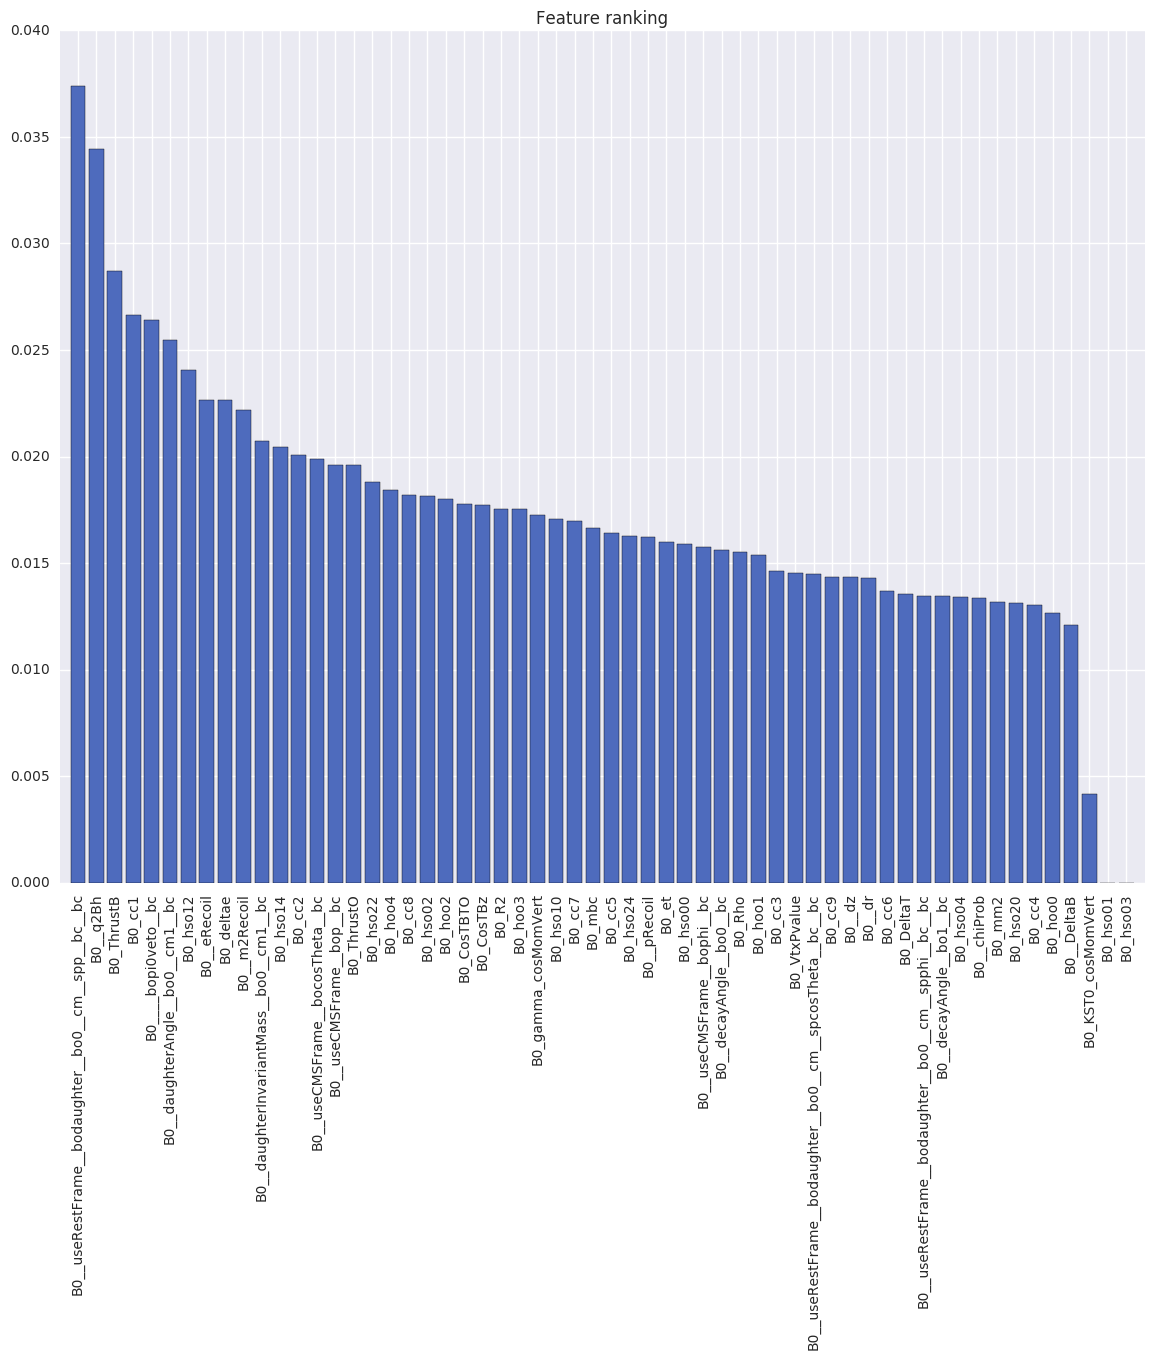

In [395]:
plot_feature_rank(bdt, sig_tree_names[0], branch_names)

1. feature 55 - B0__useRestFrame__bodaughter__bo0__cm__spp__bc__bc `(0.053019)
2. feature 35 - B0__useCMSFrame__bop__bc `(0.031973)
3. feature 56 - B0__useRestFrame__bodaughter__bo0__cm__spcosTheta__bc__bc `(0.029301)
4. feature 54 - B0____bopi0veto__bc `(0.028873)
5. feature 0 - B0_ThrustB `(0.028401)
6. feature 46 - B0__daughterInvariantMass__bo0__cm1__bc `(0.025686)
7. feature 32 - B0__q2Bh `(0.025525)
8. feature 36 - B0__useCMSFrame__bocosTheta__bc `(0.025219)
9. feature 53 - B0__m2Recoil `(0.024939)
10. feature 38 - B0_deltae `(0.024413)
11. feature 39 - B0_mbc `(0.023026)
12. feature 5 - B0_cc1 `(0.022970)
13. feature 2 - B0_CosTBTO `(0.022604)
14. feature 41 - B0__decayAngle__bo1__bc `(0.022254)
15. feature 52 - B0__eRecoil `(0.021707)
16. feature 22 - B0_hso12 `(0.021566)
17. feature 45 - B0__daughterAngle__bo0__cm1__bc `(0.020782)
18. feature 40 - B0__decayAngle__bo0__bc `(0.020034)
19. feature 26 - B0_hso24 `(0.019625)
20. feature 57 - B0__useRestFrame__bodaughter__bo0__cm__s

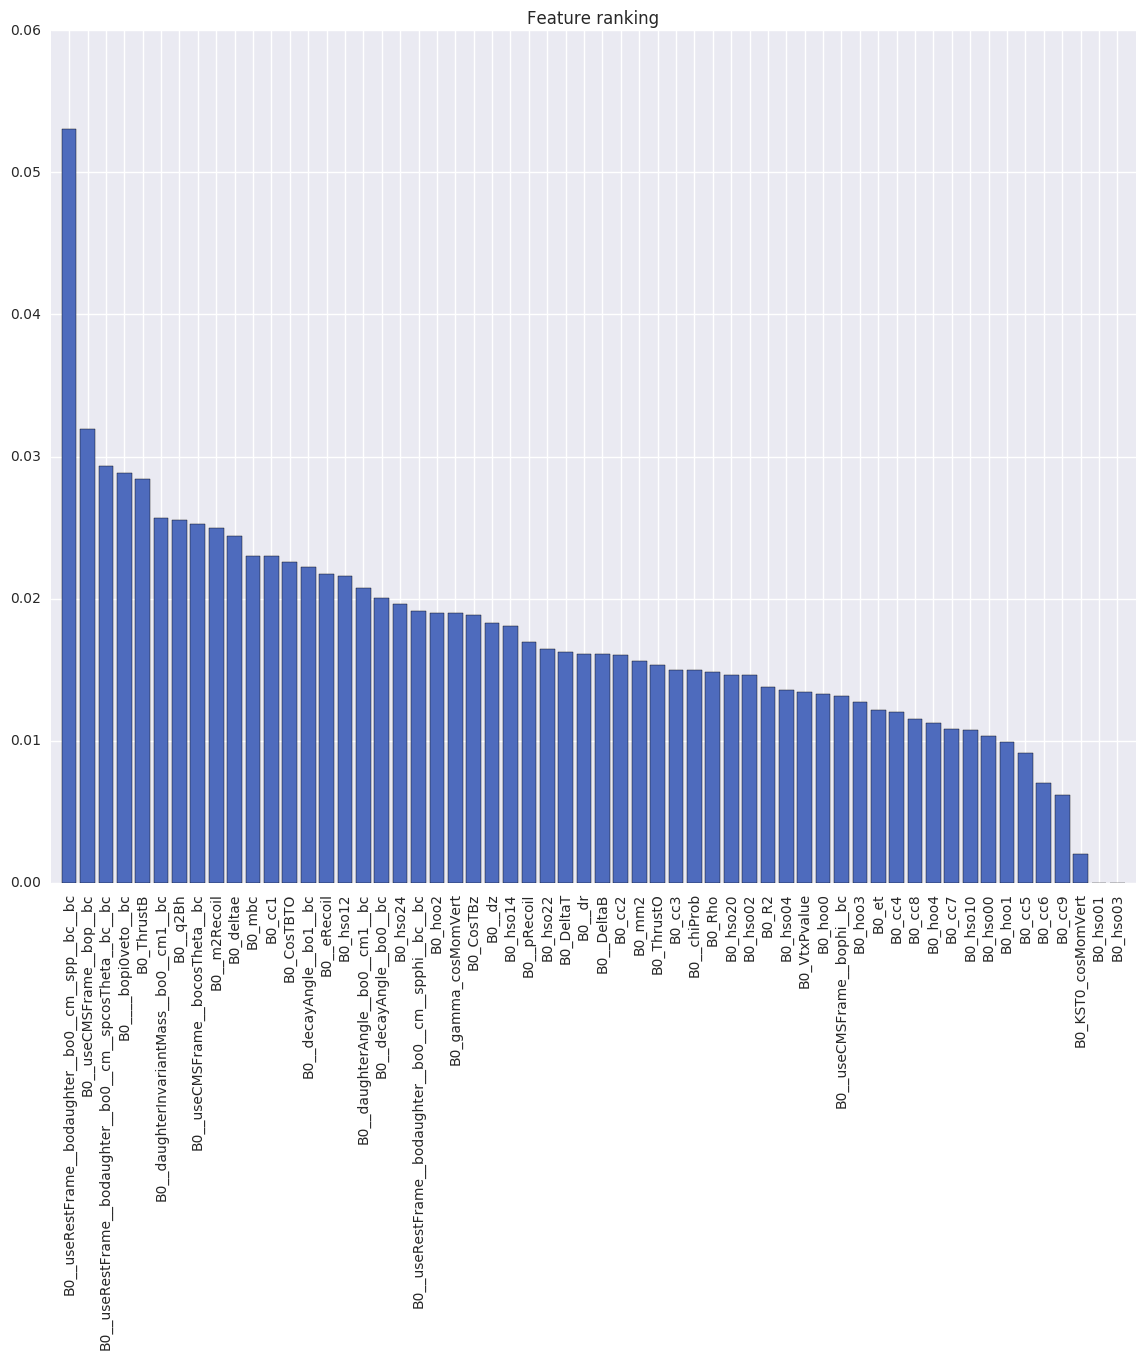

In [394]:
plot_feature_rank(gbt, sig_tree_names[0], branch_names)

### BDT Output Distribution

A classic ROOT plot. The BDT output for the training sample is plotted as a solid histogram. The corresponding output for the validation sample is overlaid in the form of error bars (a la ROOT style). If no overtraining has occurred, the plots should roughly coincide. 

**Note**: Two different versions - one for balanced classes (which plots entries per bin), and another for unbalanced classes (which plots fractional entries per bin). It is generally recommended to train with balanced classes, although it is possible to invoke certain options during classifier training to mitigate the effect of unbalanced labels. See `scikit-learn` documentation for further details,

In [475]:
def plot_BDT_output(clf, X_train, X_test, y_train, y_test, tree_name, meta_info, numbins):
    # Plot classifier decision function for each class. superimpose classifier output for
    # training sample and the independent validation sample to check for overfitting. No 
    # error bars
    
    decisions, fracweights = [], []
    # Run classifier on train, test data. Unravel to flattened array
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1,d2]

    for i in range(len(decisions)):
        #knuthbins.append(knuth_bin_width(decisions[i], return_bins = True)[1])
        #bins = bayesian_blocks(decisions[0])
        decisions[i] = truncate_tails(decisions[i],nsigma=5)
        fracweights.append(np.ones(decisions[i].shape[0])*1/decisions[i].shape[0])
        print(np.min(decisions[i]),np.max(decisions[i]))
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    hist_range = (low,high)
    if abs(low) > 100 or abs(high) > 100:
        hist_range = (-25,25)
        
    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, 'BDT Output', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')

    # Histogram training data
    plt.hist(decisions[0], color = 'g', alpha = 0.35, range = hist_range, bins = numbins, histtype='stepfilled', label='Signal (train)', weights = fracweights[0])
    plt.hist(decisions[1], color = 'b', alpha = 0.35, range = hist_range, bins = numbins, histtype='stepfilled', label='Background (train)', weights = fracweights[1])

    # Overlay training histogram with test data histogram, plotted as error-bar histograms
#     hist, bins = np.histogram(decisions[2], bins=knuthbins[2], range=hist_range, weights = fracweights[2])
#     center = (bins[:-1] + bins[1:])/2

    hist, bins = np.histogram(decisions[2], bins=numbins, range=hist_range, weights = fracweights[2])
    center = (bins[:-1] + bins[1:])/2
    
    plt.errorbar(center, hist, fmt='o',c='g', label = 'Signal (test)')

#     hist, bins = np.histogram(decisions[3], bins=knuthbins[3], range=hist_range, weights = fracweights[3])
#     center = (bins[:-1] + bins[1:])/2

    hist, bins = np.histogram(decisions[3], bins=numbins, range=hist_range, weights = fracweights[3])
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, fmt='o', c='b', label = 'Background (test)')

    plt.xlabel("Classifier Output\n" + meta_info)
    plt.ylabel("Fraction per bin")
    plt.legend(loc='best')
    plt.savefig("graphs/" + tree_name + "BDToutput.png")
    plt.show()
    plt.gcf().clear()

In [ ]:
# Plot BDT output for signal/background events
plot_BDT_output(gbt, X_train, X_test, y_train, y_test, 'b0-tree', clf_meta, 30)

-0.0294285381569 0.0701826066358
-0.150870505232 0.0216126133661
-0.0339033506274 0.0700308532721
-0.14534245806 0.0315207295075


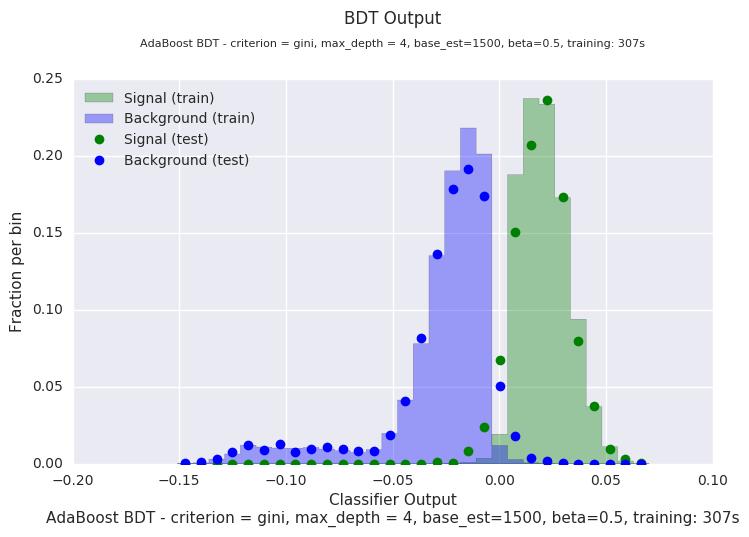

In [576]:
# Plot BDT output for signal/background events
plot_BDT_output(bdt, X_train, X_test, y_train, y_test, 'b0-tree', clf_meta, 30)

In [107]:
compare_train_test(bdt, X_train, y_train, X_test, y_test)

In [108]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.show()

## Figure of Merit

Define the figure of merit as $$ \mathrm{FOM} = \frac{S}{\sqrt{S+B}} $$ Where $S$ and $B$ are the number of signal and background events, as determined by cutting on the BDT output threshold. We aim to find the cut on the classifier output maximizing the signal significance. Other FOMs can easily be handled.

In [526]:
def plot_FOM(clf, X, y, meta_info):
    signal = clf.decision_function(X[y > 0.5])
    background = clf.decision_function(X[y < 0.5])
    start = min(background.min(), signal.min())
    end = max(background.max(), signal.max())
    if abs(start) > 100 or abs(end) > 100:
            prange = (-25,25)   
    else:
        prange = (start,end)
    cuts = np.linspace(prange[0] + 0.1, prange[1] - 0.1, 100)

    FOM = []
    for cut in cuts:
        S = (signal > cut).sum()
        B = (background > cut).sum()
        FOM.append(S/np.sqrt(S+B))
    FOM = np.asarray(FOM)
    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, r'$\mathrm{Signal \; significance}$', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')
    opt = cuts[np.argmax(FOM)]
    plt.plot((opt, opt), (0, FOM.max()), 'r--')
    plt.plot(cuts, FOM, 'o', color='navy', markersize=4)
    plt.xlim(prange)
    plt.xlabel(r'$\mathrm{BDT \; output}$')
    plt.ylabel(r'$\frac{S}{\sqrt{S+B}}$')
    plt.show()

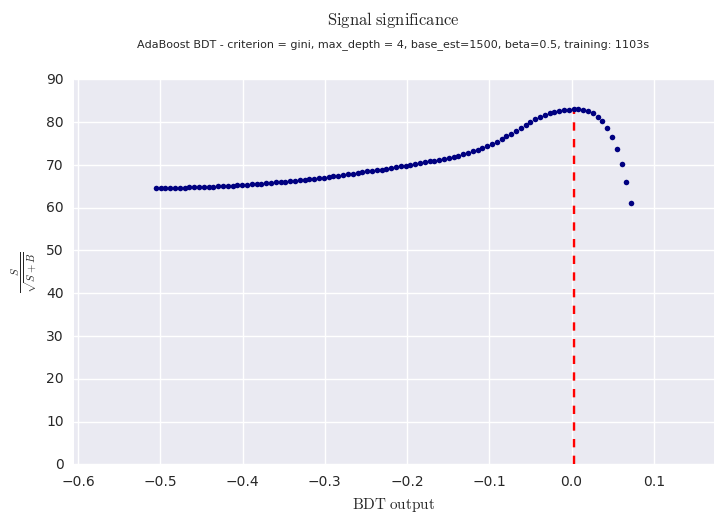

In [527]:
plot_FOM(bdt, X_val, y_val,clf_meta)

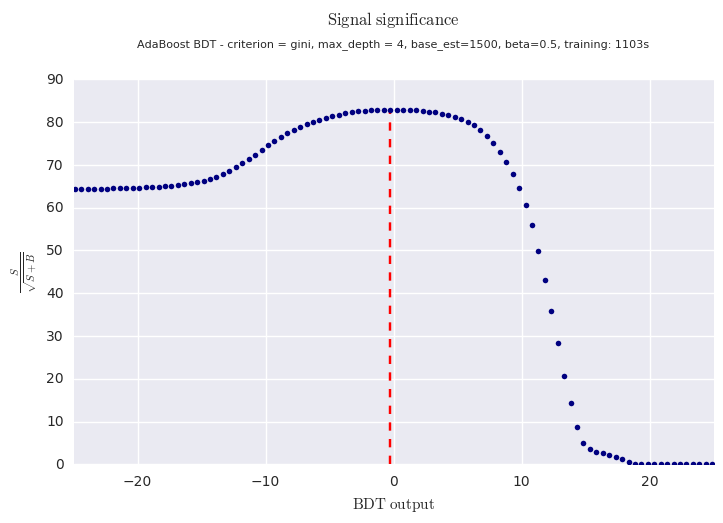

In [528]:
plot_FOM(gbt, X_val, y_val, clf_meta)

## Cross Validation

Searching through hyperparameter space presents the risk that the hyperparameters can be adjusted such that classifier learns the 'noise' of the test set and hence generalizes poorly - an undesirable circumstance called *overfitting*. $k$-fold CV parititons the training set into $k$ smaller sets: $k-1$ of the folds are used as training data, and the remaining data is used as validation. The final accuracy reported by $k$-fold CV is the average of the accuracy over $k$ iterations. 

This method does not restrict the number of training samples available, but is computationally expensive and may not be worth undertaking for the marginal improvement it provides. As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to Leave-One-Out. <cite data-cite="FHT2009">(HFT, 2009)</cite>

Here we opt for random permutation cross-validation. Samples are first shuffled and then split into a pair of train/test sets. Compared to `KFold` cross-validation, this allows a finer control on the train-test split proportion and the number of validation iterations.

In [ ]:
X_CV, X_test2, y_CV, y_test2 = train_test_split(features, labels,
                                              train_size=25000,
                                              test_size=10000,
                                              random_state=314)

In [ ]:
# Could change classifiers here
# Set model hyperparameters
CRITERION = "gini"
MAX_DEPTH = 5
MIN_SAMPLES_LEAF = 0.02 
MIN_IMPURITY_SPLIT = 1e-7
clf_meta = "AdaBoost BDT - criterion=Gini, max_depth=5, n_est=800, beta=0.5"

# Select base classifier
dt = DecisionTreeClassifier(criterion = CRITERION, max_depth = MAX_DEPTH, min_samples_leaf = MIN_SAMPLES_LEAF, class_weight="balanced") 

# Adaptive boosting algorithm
bdt = AdaBoostClassifier(dt, n_estimators = 800, learning_rate = 0.5)

A [large pool of error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) exist for binary classification. We choose AUC as the test metric during cross-validation, as it is unaffected by the balance of class labels, unlike accuracy.

#### Random permutation X-Val

In [ ]:
from sklearn import cross_validation
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size = 0.1, random_state = 314)

%time scores = cross_validation.cross_val_score(bdt, X_CV, y_CV, cv=cv.split(X_CV), scoring = 'roc_auc', n_jobs=-1, verbose=1)

In [ ]:
print("Cross-Val accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

#### Conventional X-Val

In [ ]:
# Traditional X-val
%time scores = cross_validation.cross_val_score(bdt, X_CV, y_CV, cv=4, scoring = 'roc_auc', n_jobs=-1, verbose=1)

In [ ]:
print("Cross-Val accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

#### Random permutation + Stratification X-Val

This should be run if your classification problem suffers a class imbalance. Stratified sampling attempts to preserve relative class frequencies in each of the train/validation folds.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size = 0.1, random_state = 314)

%time scores = cross_validation.cross_val_score(bdt, X_CV, y_CV, cv=cv.split(X_CV), scoring = 'roc_auc', n_jobs=-1, verbose=1)

## Hyperparameter Estimation

Hyperparameters are 'meta-parameters' that are not directly learnt by the algorithm. They are instead passed to the algorithm by the user (eg the number of trees and their maximum depth for BDTs, and the weight decay and dropout probability for neural networks). The optimal set of hyperparameters is context-dependent. 

Cross-validation is a common technique used to scan through hyperparameter space to find a suitable set for the problem at hand.

In [ ]:
# Display hyperparameters for our chosen classifier
bdt.get_params()

### Conventional grid search

In [ ]:
from sklearn import grid_search

# Perform grid search over all combinations of the following hyperparameters
param_grid = [
    {'n_estimators': [100,300,500,1000,1200], 
     'learning_rate': [0.1,0.3,0.8],
     'base_estimator__max_depth': [1,2,3,7]}
#     {'n_estimators': [100,300,500,1000,1200], 
#      'learning_rate': [0.1,0.2,0.8]
#      'max_depth': {1,2,3,7},
#      "base_estimator__criterion" : ["gini", "entropy"],
#      "base_estimator__splitter" :   ["best", "random"}
]

gs = grid_search.GridSearchCV(bdt, param_grid, cv=4, scoring = 'roc_auc', n_jobs=-1)
%time gs.fit(X_CV, y_CV)

### Randomized parameter optimization

If the classifier at hand has many hyperparameters, a brute force grid search may be prohibitively time-consuming. Randomized parameter estimation samples from a specified distribution over possible parameter values and evaluates the classifier performance at random points in hyperparameter space. This can be less computionally intensive than a conventional grid search. 

Additionally, `scikit-learn` offers the option to specify a computational budget - either the number of sampled candidates or sampling iterations. We need access to the distributions in the `scipy.stats` module to sample parameters. 

In [ ]:
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV

# Specify parameter distributions
param_dist = {"base_estimator__max_depth": [3,5,7,None],
              #"base_estimator__criterion": ["gini", "entropy"],
              "base_estimator__max_features": scipy.stats.randint(np.sqrt(len(branch_names)),len(branch_names)),
              "n_estimators": scipy.stats.randint(500,1900),
              "learning_rate": scipy.stats.uniform(loc = 0.3, scale = 0.7)}

In [ ]:
# run the search
n_iter = 100
rs = RandomizedSearchCV(bdt, param_distributions = param_dist, n_iter=n_iter, cv=4, scoring = 'roc_auc', n_jobs=-1, verbose=1)
%time rs.fit(X_CV, y_CV)

### Parameter search report

In [ ]:
def CV_report(gs_results, rs_results):
    # Reporting on x-val scores
    print("")

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
CV_report(gs.cv_results_, rs.cv_results_)

### `TO-DO (2):`
    - Validation curves
    - Randomized grid search
    - Develop better metric for CV
    - Ensemble classifiers
    - **Data transformation with held out data** (!!!)
    - Look into pipelines

## References

<cite data-cite="granger2013">(Friedman, Hastie, Tibshirani, Elements of Statistical Learning, Springer, 2009)</cite>

<cite data-cite="granger2013">(Louis Lyons, Statistics for Nuclear and Particle Physicists, Cambridge University Press, 1986)</cite>

<cite data-cite="baumgartl2014">(Darin Baumgartel, scikit-learn versus TMVA)</cite> https://dbaumgartel.wordpress.com/2014/03/14/machine-learning-examples-scikit-learn-versus-tmva-cern-root/

<cite data-cite="baumgartl2014">(Tim Head, scikit-learn for TMVA users)</cite> https://betatim.github.io/posts/sklearn-for-TMVA-users/

<cite data-cite="baumgartl2014">(Thomas Keck, The Full Event Interpretation, KiT, 2014)</cite> https://ekp-invenio.physik.uni-karlsruhe.de/record/48602/files/EKP-2015-00001.pdf

<cite data-cite="LB, AC"> (L. Breiman, and A. Cutler, “Random Forests”)</cite> http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

<cite data-cite="baumgartl2014">(Scikit-Learn v0.18.01 Documentation, 2017)</cite> https://scikit-learn.org/stable/modules/cross_validation.html
